C:\Research\LayInvest\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Pramudi\AppData\Local\Temp\ipykernel_16092\1523086380.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, conn)
13:24:45 - cmdstanpy - INFO - Chain [1] start processing
13:24:46 - cmdstanpy - INFO - Chain [1] done processing


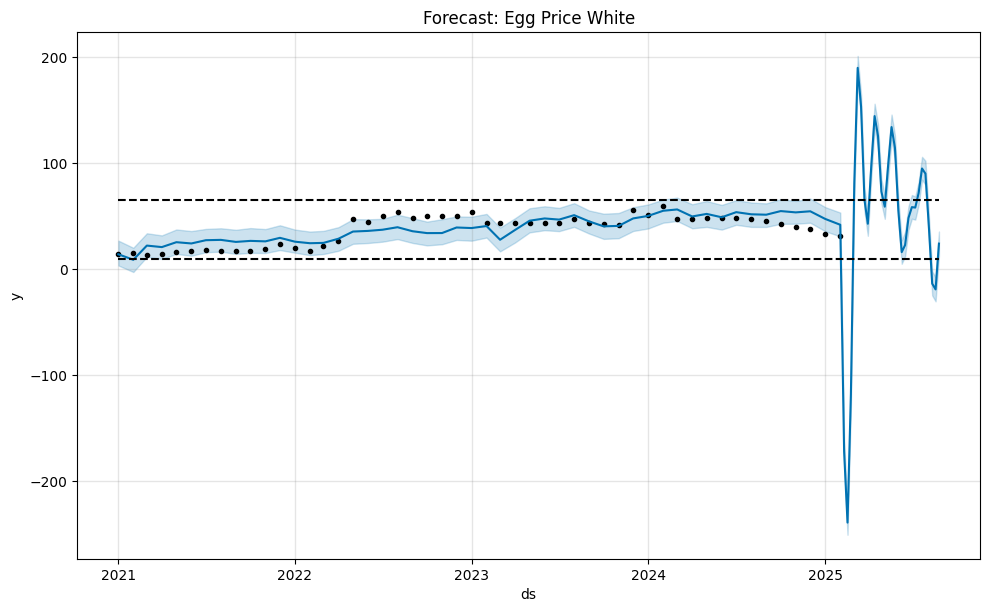

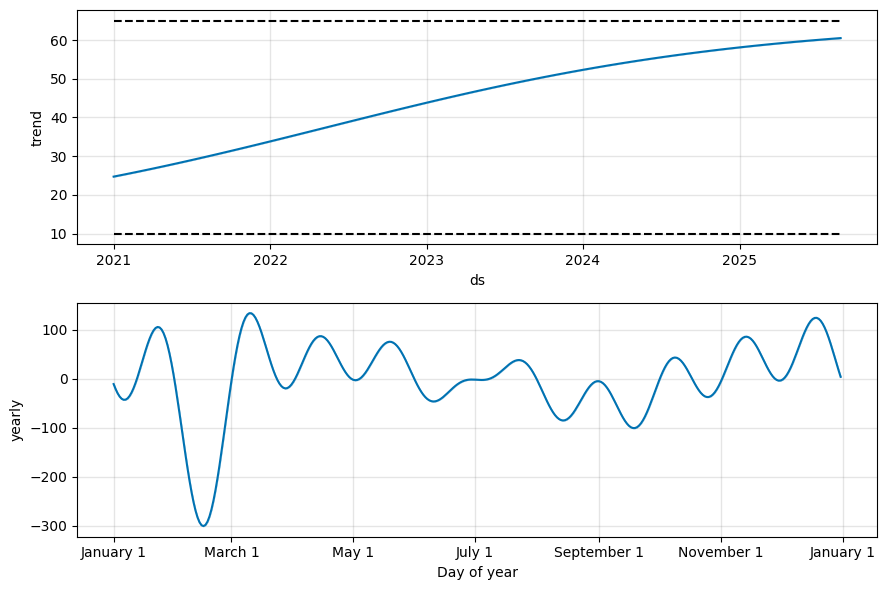

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|                                                                                                                                  | 0/35 [00:00<?, ?it/s]13:24:47 - cmdstanpy - INFO - Chain [1] start processing
13:24:48 - cmdstanpy - INFO - Chain [1] done processing
  3%|███▍                                                                                                                      | 1/35 [00:01<00:43,  1.28s/it]13:24:48 - cmdstanpy - INFO - Chain [1] start processing
13:24:50 - cmdstanpy - INFO - Chain [1] done processing
  6%|██████▉                                                                                                                   | 2/35 [00:02<00:49,  1.49s/it]13:24:50 - cmdstanpy - INFO - Chain [1] start processing
13:24:50 - cmdstanpy - INFO - Chain [1] done processing
  9%|██████████▍                                                                   

   horizon       rmse      mape
0  17 days  53.750118  0.777034
1  18 days  37.914628  0.549582
2  19 days  24.780550  0.454497
3  20 days  26.697905  0.512407
4  21 days  26.111716  0.528984
5  22 days  24.744868  0.500793
6  23 days  22.842372  0.463737
7  24 days  19.439049  0.367453
8  25 days  16.357340  0.307769
9  26 days  15.114205  0.281546
10 27 days  14.756857  0.289790
11 28 days  19.131596  0.388674
12 42 days  19.357289  0.438251
13 43 days  20.105595  0.473647
14 44 days  21.738972  0.508820
15 45 days  25.902755  0.565211
16 46 days  25.237694  0.527094
17 47 days  24.438594  0.434073
18 48 days  25.565048  0.440398
19 49 days  21.863405  0.409283
20 50 days  23.091249  0.445921
21 51 days  21.697640  0.432401
22 52 days  20.064554  0.404195
23 53 days  18.079297  0.373347
24 54 days  15.569374  0.298659
25 55 days  13.646521  0.260147
26 56 days  13.128063  0.246141
27 57 days  13.176408  0.252388
28 58 days  16.040199  0.321594
29 59 days  17.123236  0.369436
30 73 da

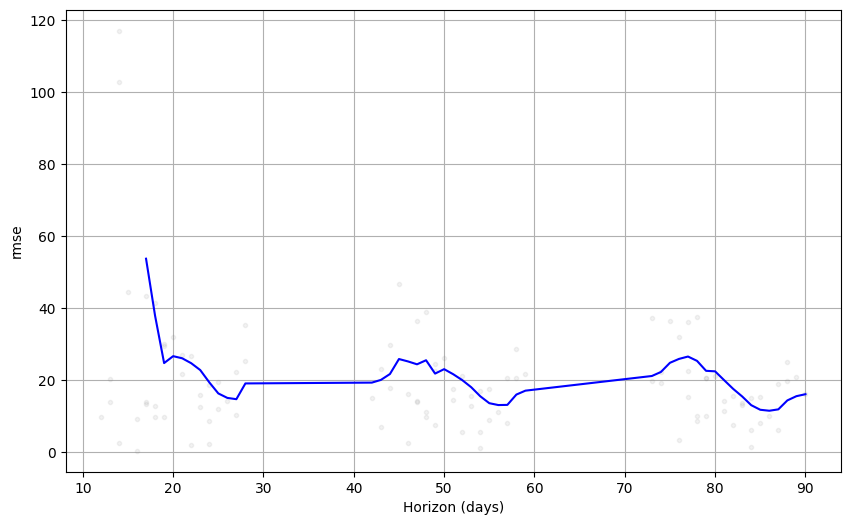

In [ ]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
import psycopg2
import os

#initial="365 days" → The first 1 year of data was used to train the model before testing starts.

#period="30 days" → After each training/test split, the window moves forward by 30 days and repeats.

#horizon="90 days" → Each test forecasts 90 days into the future, which is compared against actuals.

# --- Connect to DB ---
conn = psycopg2.connect(
    host=os.getenv("PGHOST","localhost"),
    port=os.getenv("PGPORT","5432"),
    dbname=os.getenv("PGDATABASE","layinvest_db"),
    user=os.getenv("PGUSER","postgres"),
    password=os.getenv("PGPASSWORD","admin123")
)

# --- Load one series (egg_price_white as example) ---
sql = """
    SELECT ds, value
    FROM oc.price_history_raw
    WHERE series_name='egg_price_white'
    ORDER BY ds
"""
df = pd.read_sql(sql, conn)
df["ds"] = pd.to_datetime(df["ds"])
df.rename(columns={"value":"y"}, inplace=True)

# --- Add Prophet bounds ---
df["floor"], df["cap"] = 10, 65

# --- Fit model ---
model = Prophet(growth="logistic", yearly_seasonality=True)
model.fit(df)

# --- Forecast future weeks ---
future = model.make_future_dataframe(periods=30, freq="W")
future["floor"], future["cap"] = 10, 65
forecast = model.predict(future)

# --- Plot forecast ---
fig1 = model.plot(forecast)
plt.title("Forecast: Egg Price White")
plt.show()

# --- Plot components (trend & seasonality) ---
fig2 = model.plot_components(forecast)
plt.show()

# --- Cross-validation (backtest) ---
cv = cross_validation(model, initial="365 days", period="30 days", horizon="90 days")
metrics = performance_metrics(cv)
print(metrics[["horizon","rmse","mape"]])

# --- Plot forecast error metric ---
fig3 = plot_cross_validation_metric(cv, metric='rmse')
plt.show()


In [ ]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
import psycopg2, os

# Series & bounds from your forecast.py
SERIES = {
    "feed_starter": {"min":100,"max":400},
    "feed_grower":  {"min":90,"max":400},
    "feed_layer":   {"min":80,"max":400},
    "doc_price":    {"min":60,"max":550},
    "cull_price":   {"min":100,"max":600},
    "egg_price_white": {"min":12,"max":65},
    "egg_price_brown": {"min":13,"max":65},
    "egg_price_small": {"min":10,"max":50},
}

# DB connection
conn = psycopg2.connect(
    host=os.getenv("PGHOST","localhost"),
    port=os.getenv("PGPORT","5432"),
    dbname=os.getenv("PGDATABASE","layinvest_db"),
    user=os.getenv("PGUSER","postgres"),
    password=os.getenv("PGPASSWORD","admin123")
)

# Folder to save results
os.makedirs("forecast_results", exist_ok=True)

# Loop through each series
for series, bounds in SERIES.items():
    print("="*60)
    print(f"📈 Forecasting: {series}")
    print("="*60)

    # Load history
    sql = f"""
        SELECT ds, value
        FROM oc.price_history_raw
        WHERE series_name='{series}'
        ORDER BY ds
    """
    df = pd.read_sql(sql, conn)
    if df.empty:
        print("⚠️ No data found, skipping...\n")
        continue
    
    df["ds"] = pd.to_datetime(df["ds"])
    df.rename(columns={"value":"y"}, inplace=True)

    # Apply bounds
    df["floor"], df["cap"] = bounds["min"], bounds["max"]

    # Fit model
    model = Prophet(growth="logistic", yearly_seasonality=True)
    model.fit(df)

    # Forecast next 30 weeks
    future = model.make_future_dataframe(periods=30, freq="W")
    future["floor"], future["cap"] = bounds["min"], bounds["max"]
    forecast = model.predict(future)

    # === PLOTS ===
    fig1 = model.plot(forecast)
    plt.title(f"Forecast: {series}")
    plt.savefig(f"forecast_results/{series}_forecast.png")
    plt.show()

    fig2 = model.plot_components(forecast)
    plt.savefig(f"forecast_results/{series}_components.png")
    plt.show()

    # Cross-validation
    try:
        cv = cross_validation(model, initial="365 days", period="30 days", horizon="90 days")
        metrics = performance_metrics(cv)
        print(metrics[["horizon","rmse","mape"]].head(15))  # show first 15 rows

        fig3 = plot_cross_validation_metric(cv, metric='rmse')
        plt.title(f"RMSE by horizon: {series}")
        plt.savefig(f"forecast_results/{series}_rmse.png")
        plt.show()
    except Exception as e:
        print(f"⚠️ Could not run CV for {series}: {e}\n")
